# Set up 

In [1]:
import tellurium as te
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
import pymc as pm
import numpy as np

import cobra
import os

from scipy import stats
import scipy as sp

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# import sys
# sys.path.insert(0, 'C:/Users/user/Documents/research/BMCA-pipeline')
os.chdir('../..')
from src import BMCA, util
import emll
os.chdir('notebooks/all_data/')

# Perturbing enzymes

In [7]:
Teusink_ant ='../../data/interim/Antimony/Simplified_Teusink_yeast.ant' 
data_file = '../../data/interim/generated_data/ogTeusink/Simplified_Teusink_yeast_0.99.csv'
df = pd.read_csv(data_file)

# need to fix this so only rows with concentrations less than 0 are dropped 
data = df.drop(df[df.lt(0).any(axis=1)].index)

r = te.loada(Teusink_ant)
r.conservedMoietyAnalysis = True
r.steadyState()

1.5710734600032811e-15

In [14]:
r.getScaledElasticityMatrix().shape

(16, 11)

In [20]:
s = te.loada('../../data/interim/Antimony/Simplified_Teusink_yeast_cobra.ant')
len(r.getReactionIds())
# len(r.getFloatingSpeciesIds())

16

In [12]:
BIOMD64 = BMCA.BMCA(Teusink_ant, data_file)
# BIOMD64_15 = BMCA.BMCA(Teusink_ant, '../../data/interim/generated_data/ogTeusink/BIOMD0000000064_e_extANDenzyme1.5perts.csv')
# BIOMD64_15_1000 = BMCA.BMCA(Teusink_ant, '../../data/interim/generated_data/ogTeusink/BIOMD0000000064_e_extANDenzyme1.5perts-1000.csv')

Model does not contain SBML fbc package information.


../../data/interim/Antimony/Simplified_Teusink_yeast_cobra.ant
Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-23


Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPGI>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPGI>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLYCO>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLYCO>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vTreha>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vTreha>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPFK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPFK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vALD>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vALD>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGAPDH>'
Missing upper flux bound set to '1

ValueError: Shape of passed values is (17, 14), indices imply (16, 14)

Finished [100%]: Average Loss = 12,245


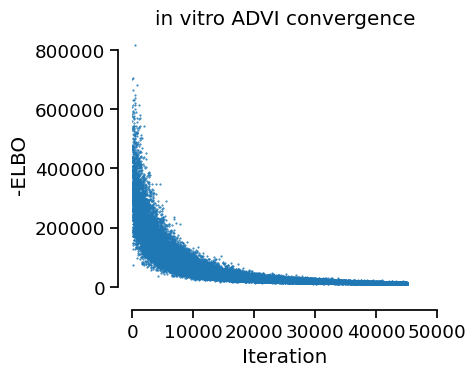

In [27]:
def run_ADVI(BMCA_obj):
    with pm.Model() as pymc_model:
        
        # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
        e_obs = pm.Normal('e_obs', mu=1, sigma=1, observed=BMCA_obj.en.T)
        chi_obs = pm.Normal('chi_obs', mu=0, sigma=10, observed=BMCA_obj.xn.T)
        y_obs = pm.Normal('y_obs', mu=0, sigma=10, observed=BMCA_obj.yn.T)
        likelihood = pm.Deterministic('vn', e_obs * (np.ones(BMCA_obj.en.T.shape) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))
        v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)
    
        N_ITERATIONS = 45000
    
    with pymc_model:
        advi = pm.ADVI()
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=       N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)
    
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, 50000])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    return approx.sample(draws=1000, random_seed=1)

trace_ADVI = run_ADVI(BIOMD64_15)

In [8]:
BMCA_obj = BIOMD64
with pm.Model() as pymc_model:
    
    # Initialize elasticities
    Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
    Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
    e_obs = pm.Normal('e_obs', mu=1, sigma=1, observed=BMCA_obj.en.T)
    pm.Deterministic('en', e_obs)
    chi_obs = pm.Normal('chi_obs', mu=0, sigma=10, observed=BMCA_obj.xn.T)
    pm.Deterministic('chin', chi_obs)
    y_obs = pm.Normal('y_obs', mu=0, sigma=10, observed=BMCA_obj.yn.T)
    pm.Deterministic('yn', y_obs)
    likelihood = pm.Deterministic('vn', e_obs * (np.ones(BMCA_obj.en.T.shape) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))
    v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)
    pm.Deterministic('v_hat', v_hat_obs)

    trace = pm.sample(1000, random_seed=1, cores=4)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: Ru

In [138]:
Ex = (trace['posterior']['Ex']).to_numpy()
Ey = (trace['posterior']['Ey']).to_numpy()
Ex_advi = (trace_ADVI['posterior']['Ex']).to_numpy().squeeze()
Ey_advi = (trace_ADVI['posterior']['Ey']).to_numpy().squeeze()

In [141]:
def reshape_elasticity(E):
    tmp = []
    for i in E: 
        tmp.append(i)
    return np.concatenate(tmp)

Ex = reshape_elasticity(Ex)
Ey = reshape_elasticity(Ey)

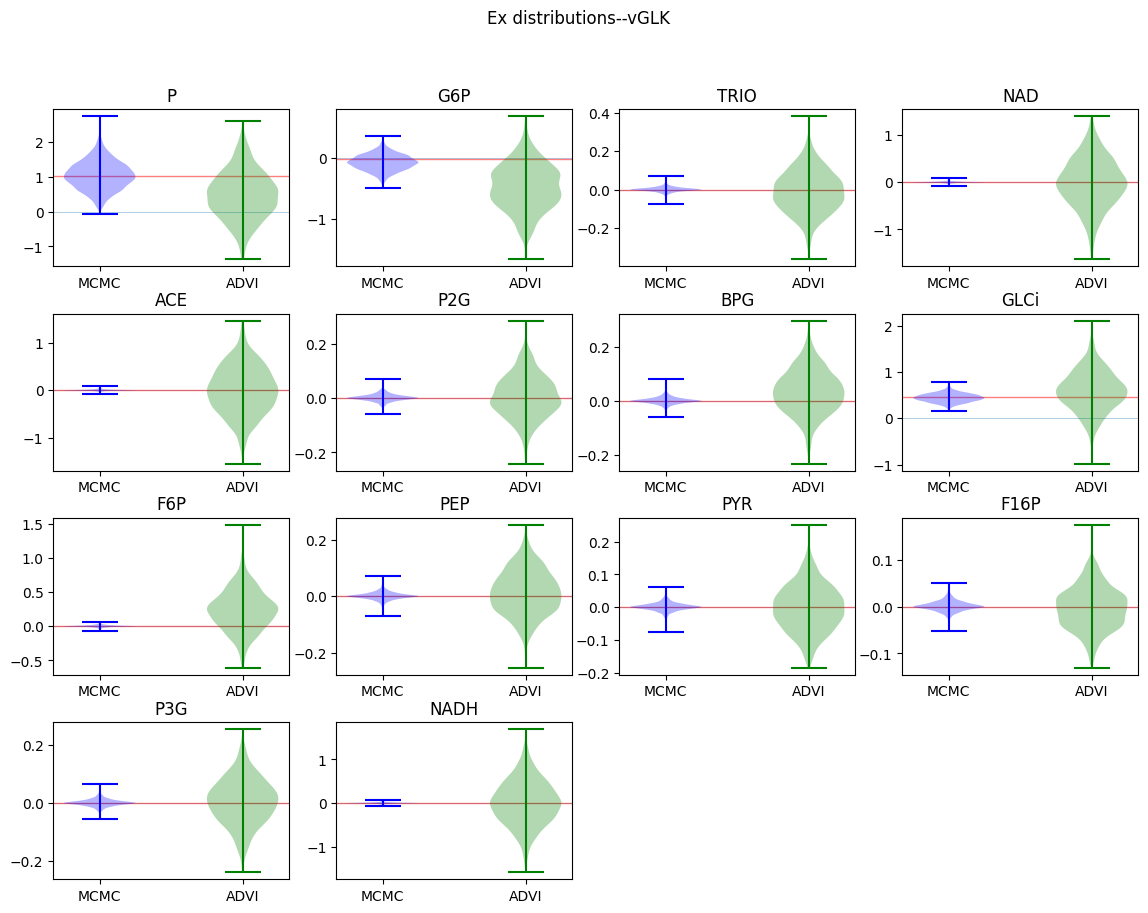

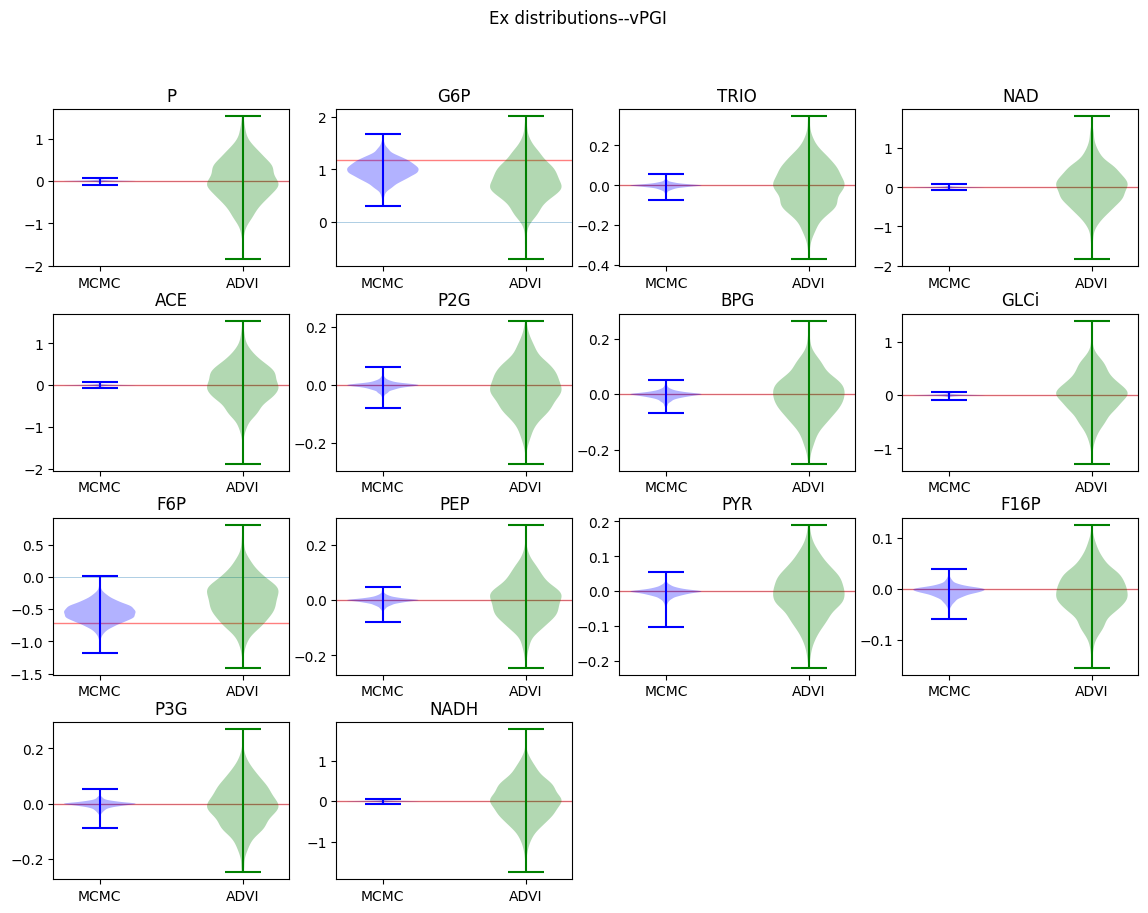

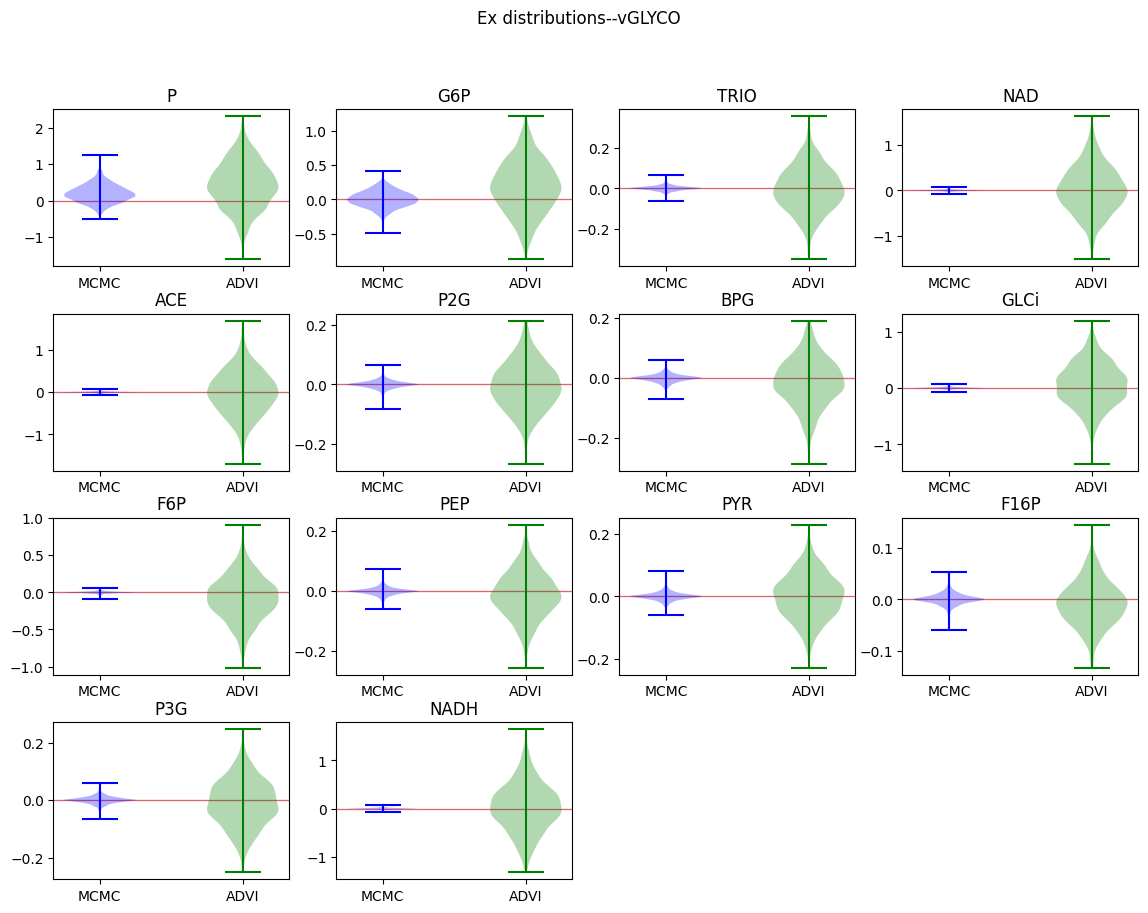

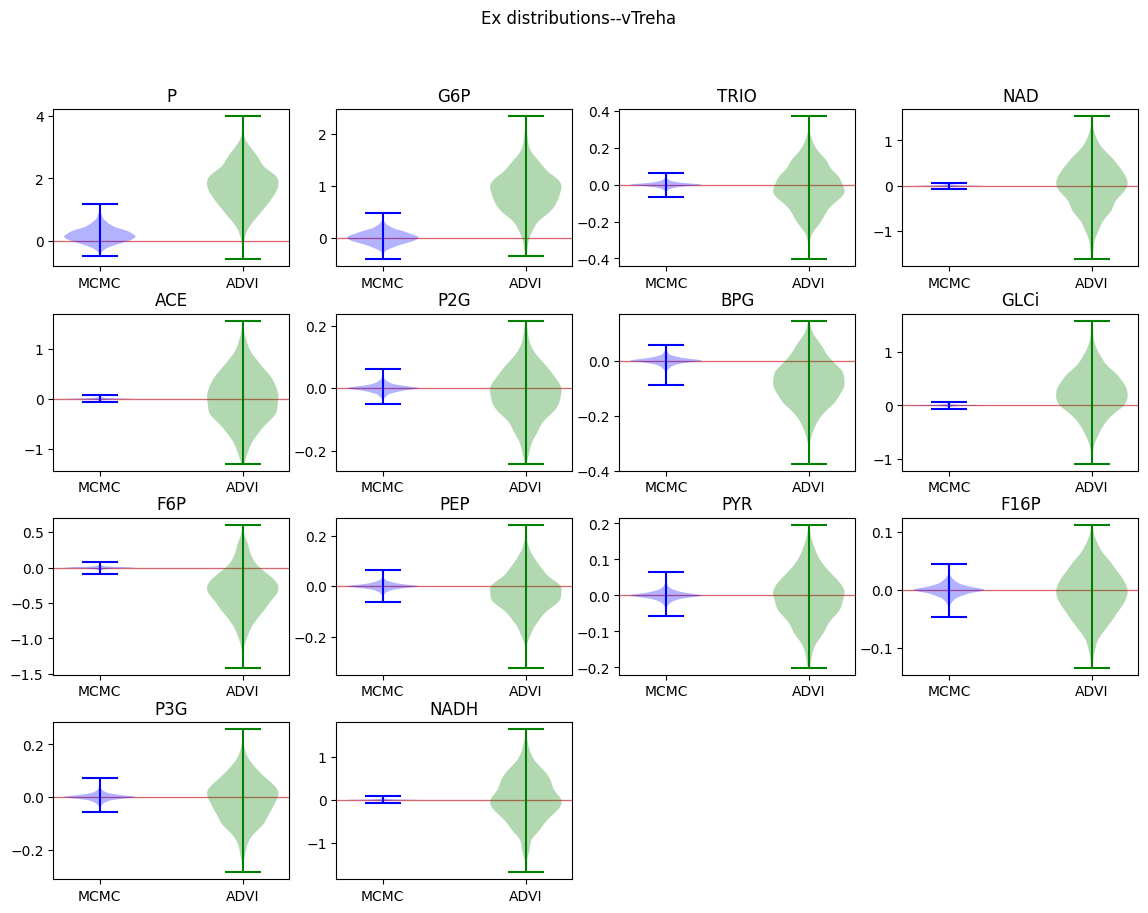

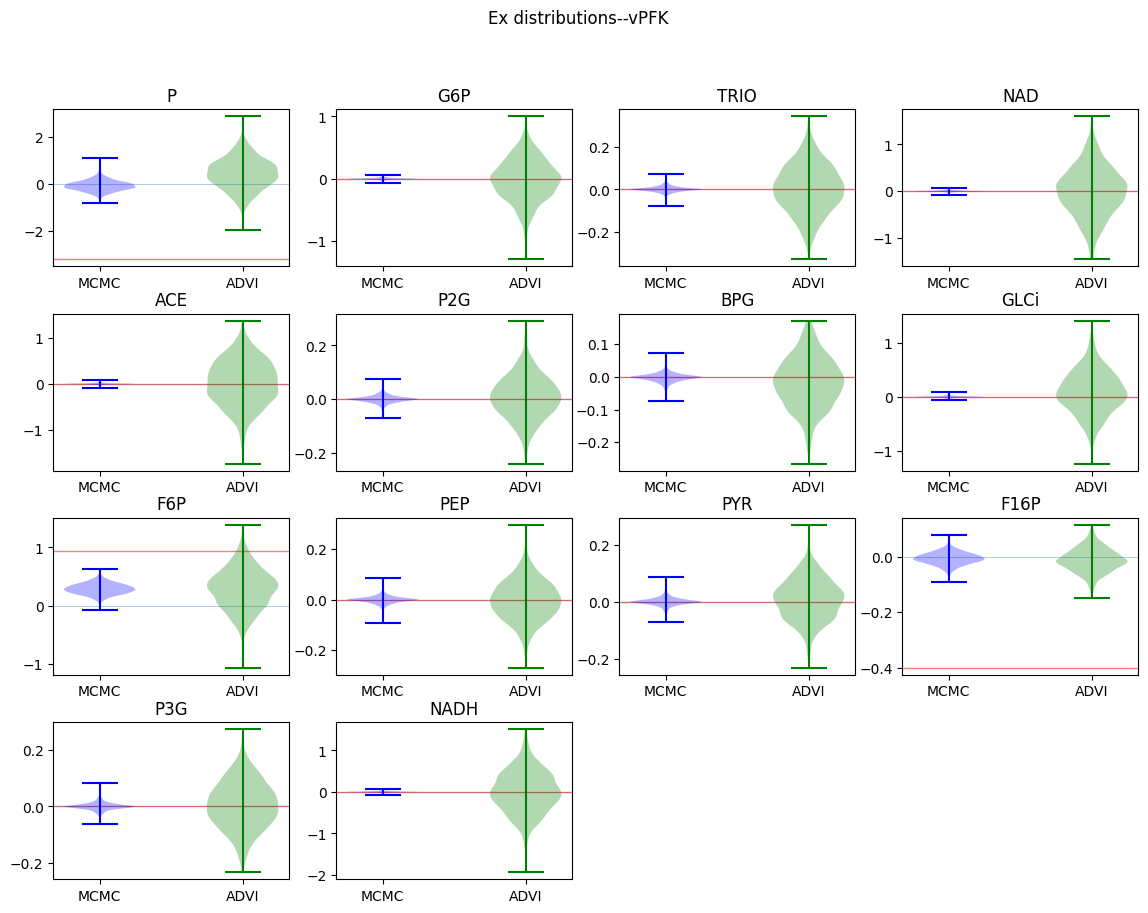

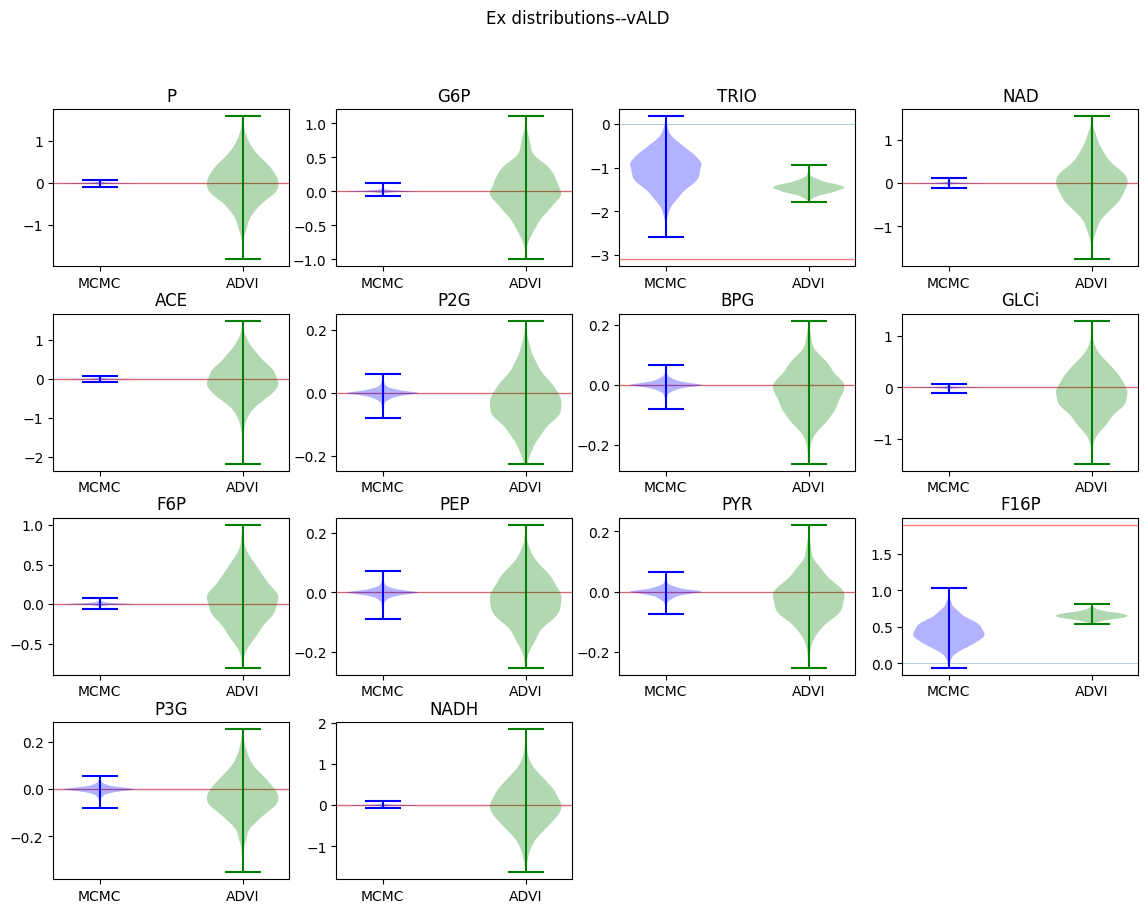

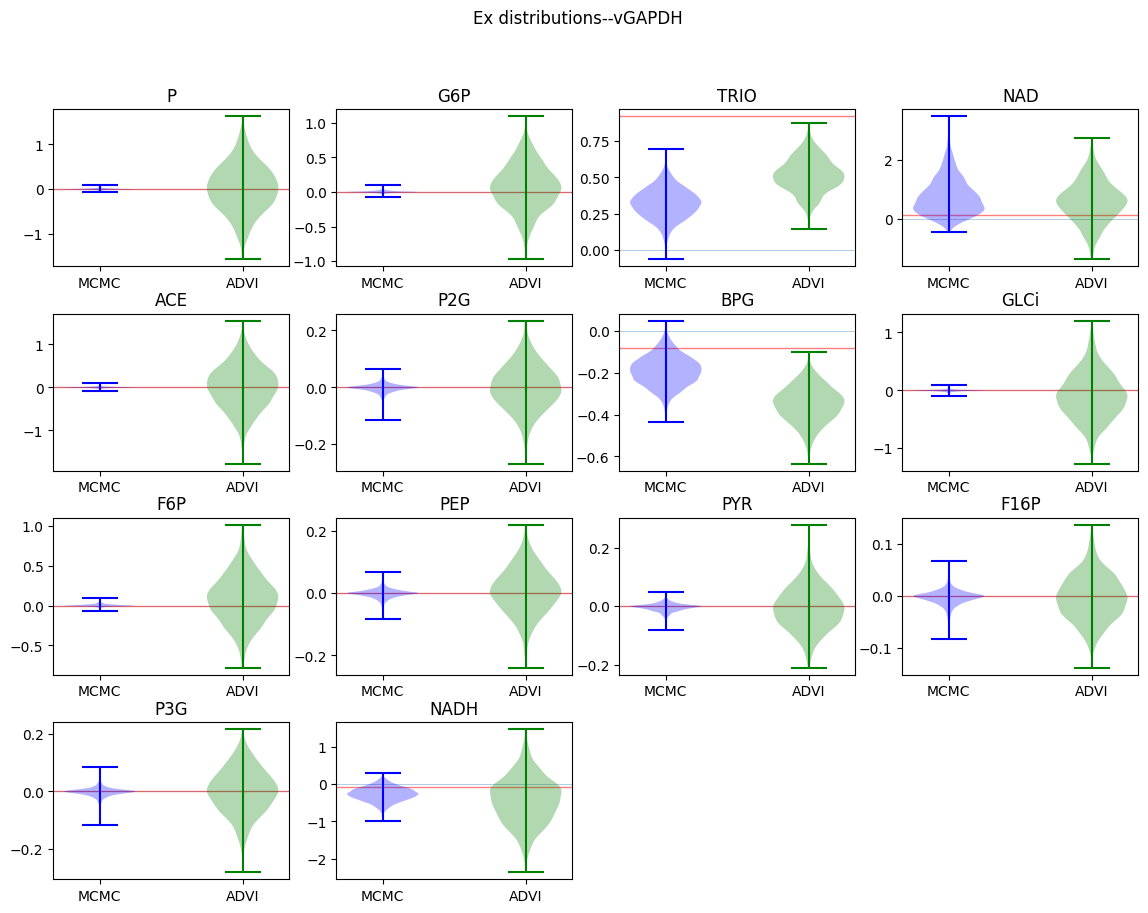

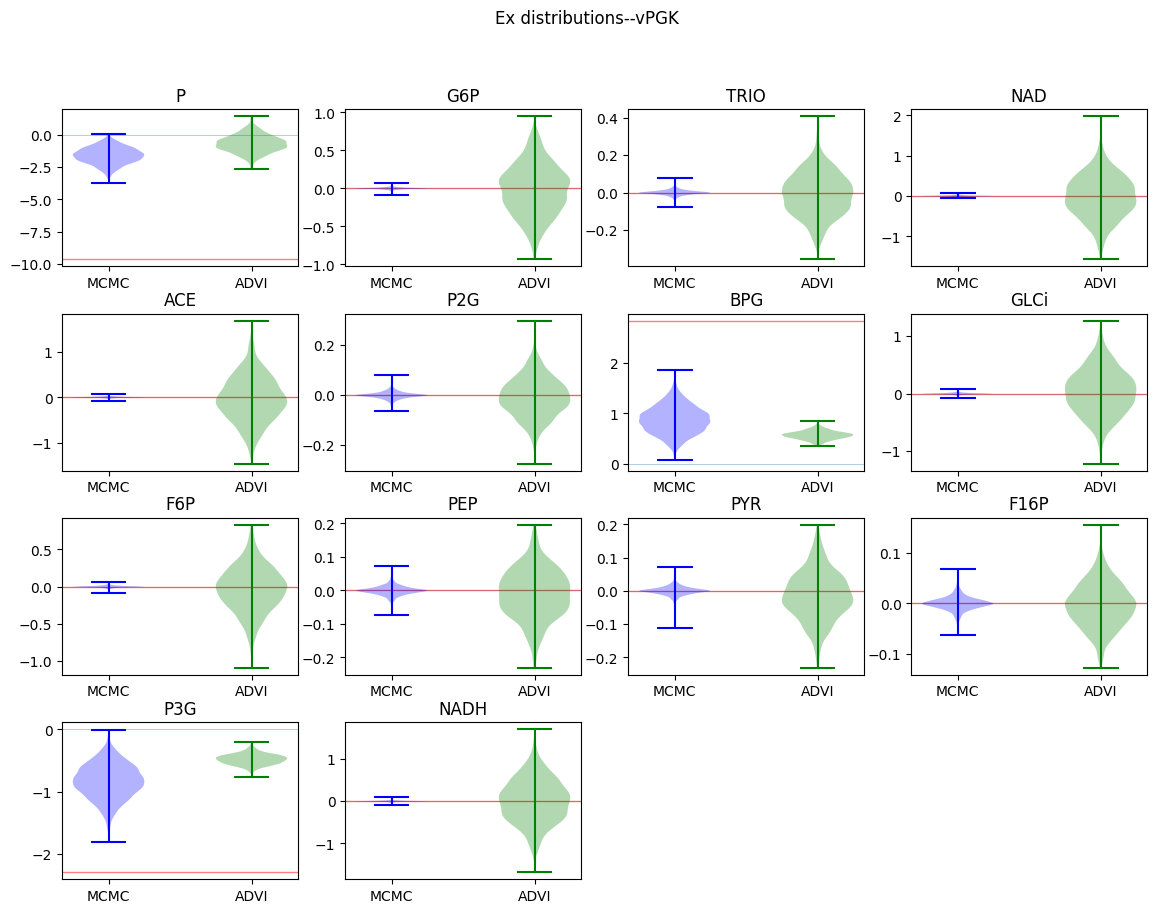

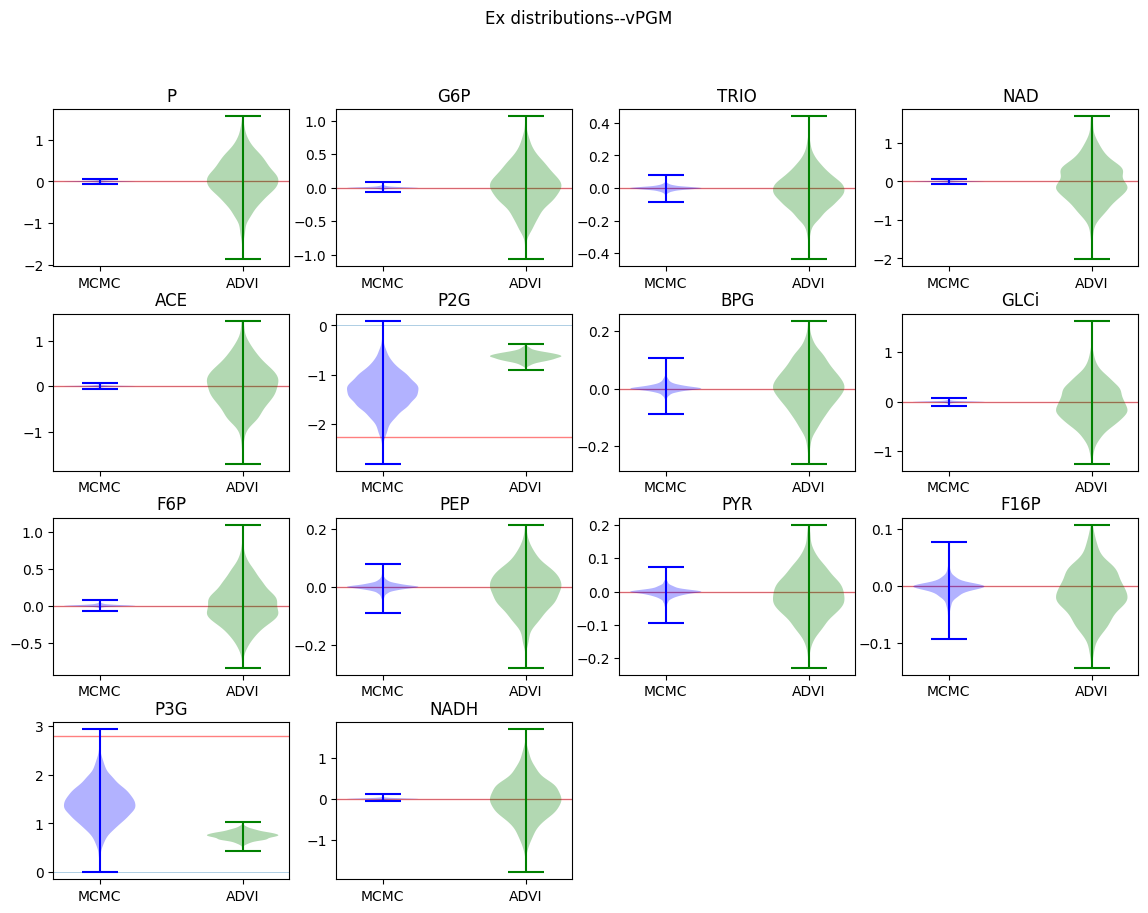

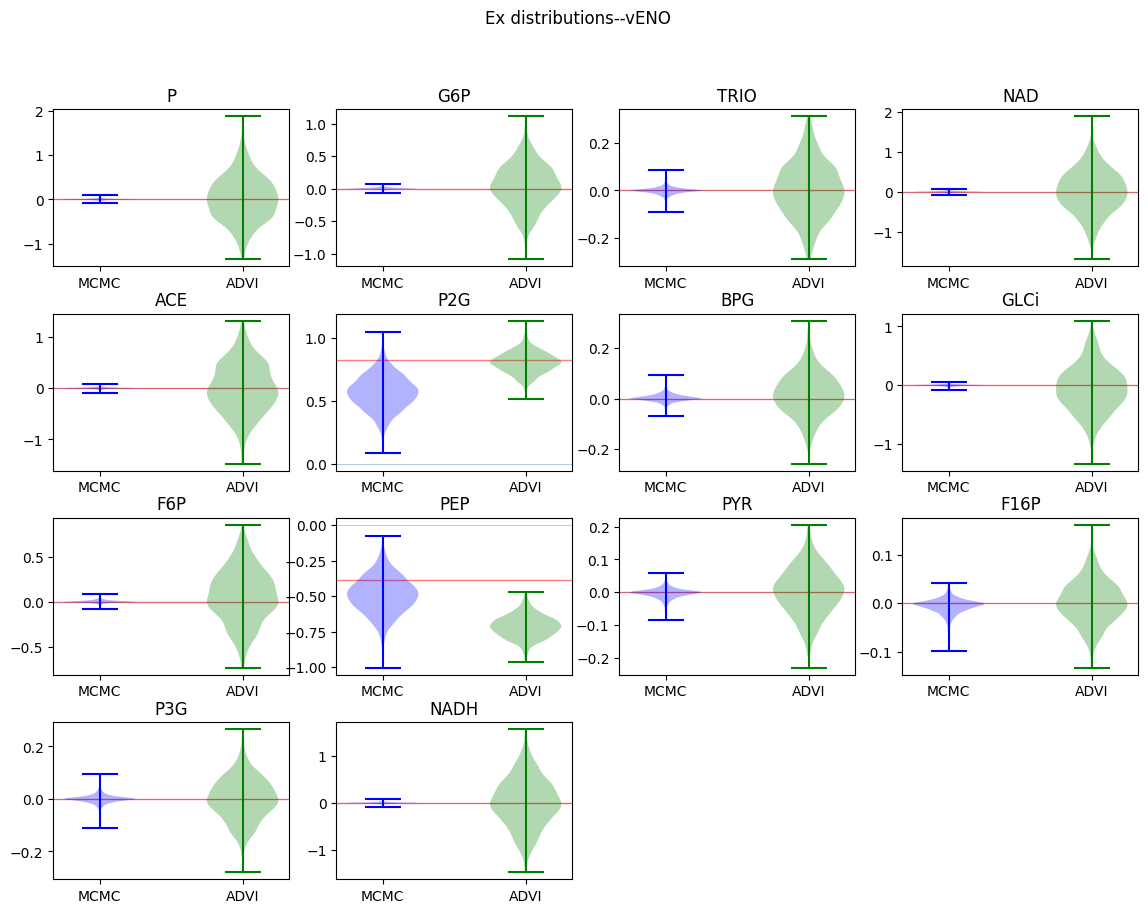

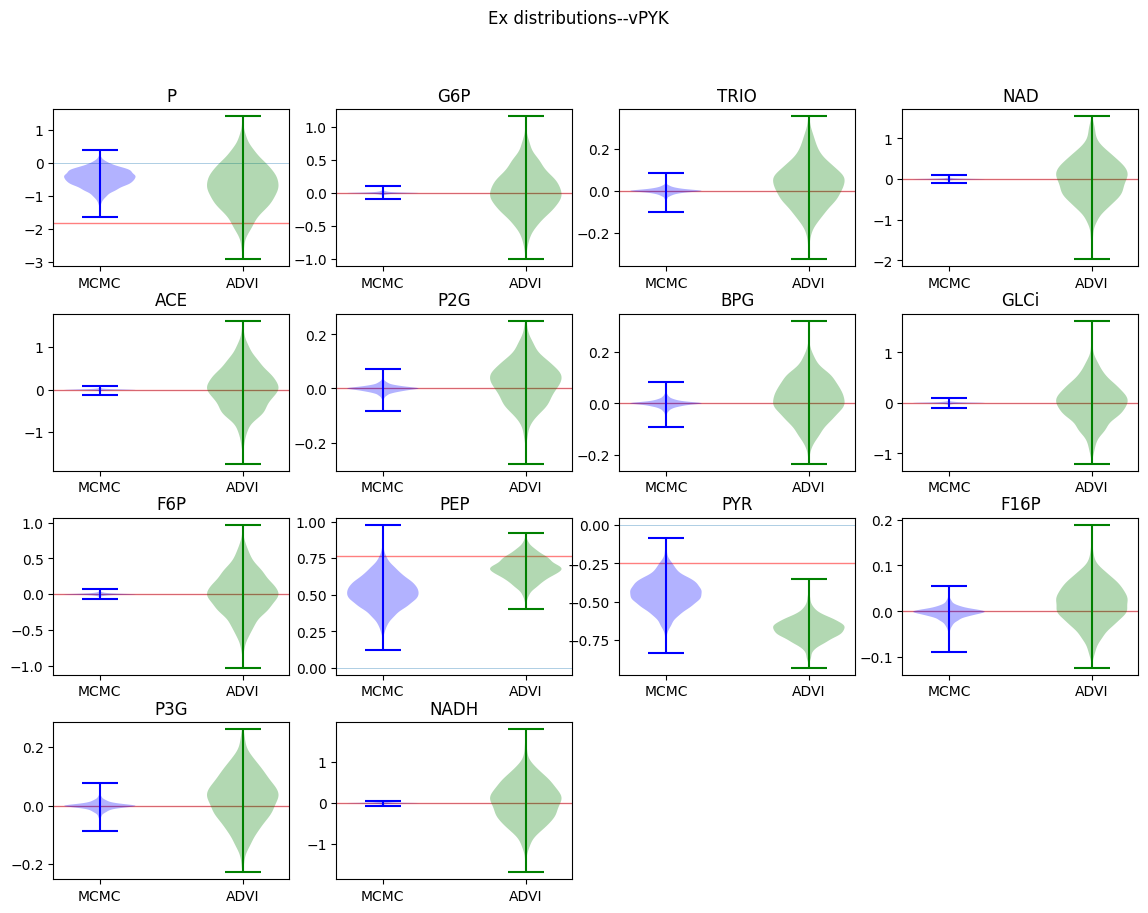

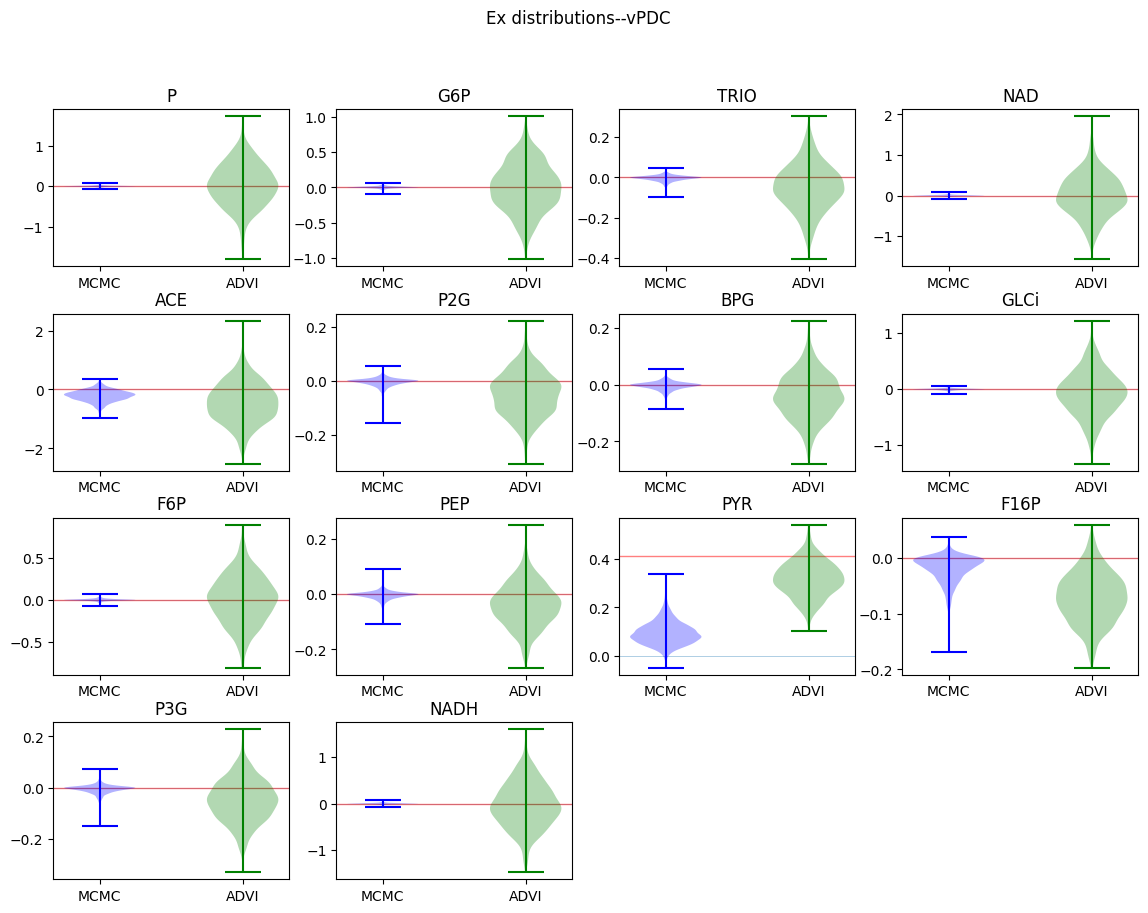

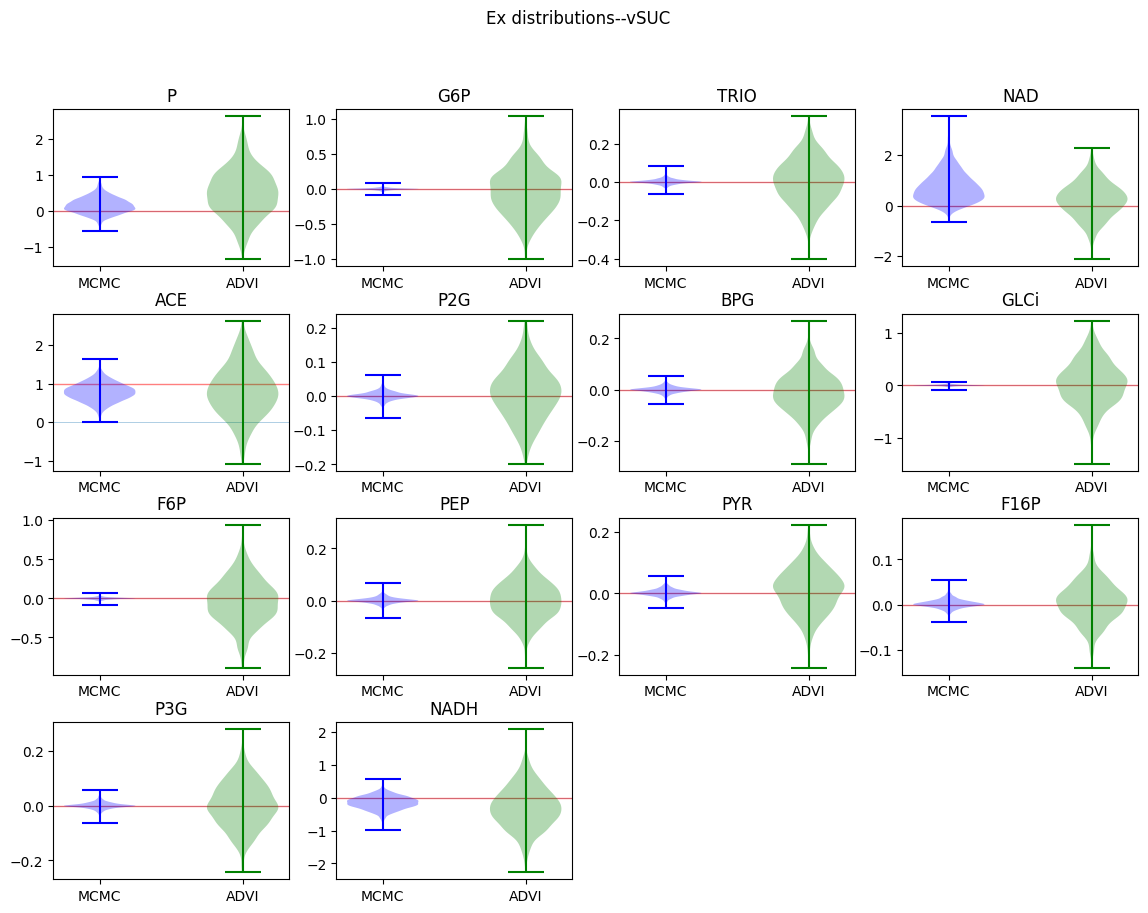

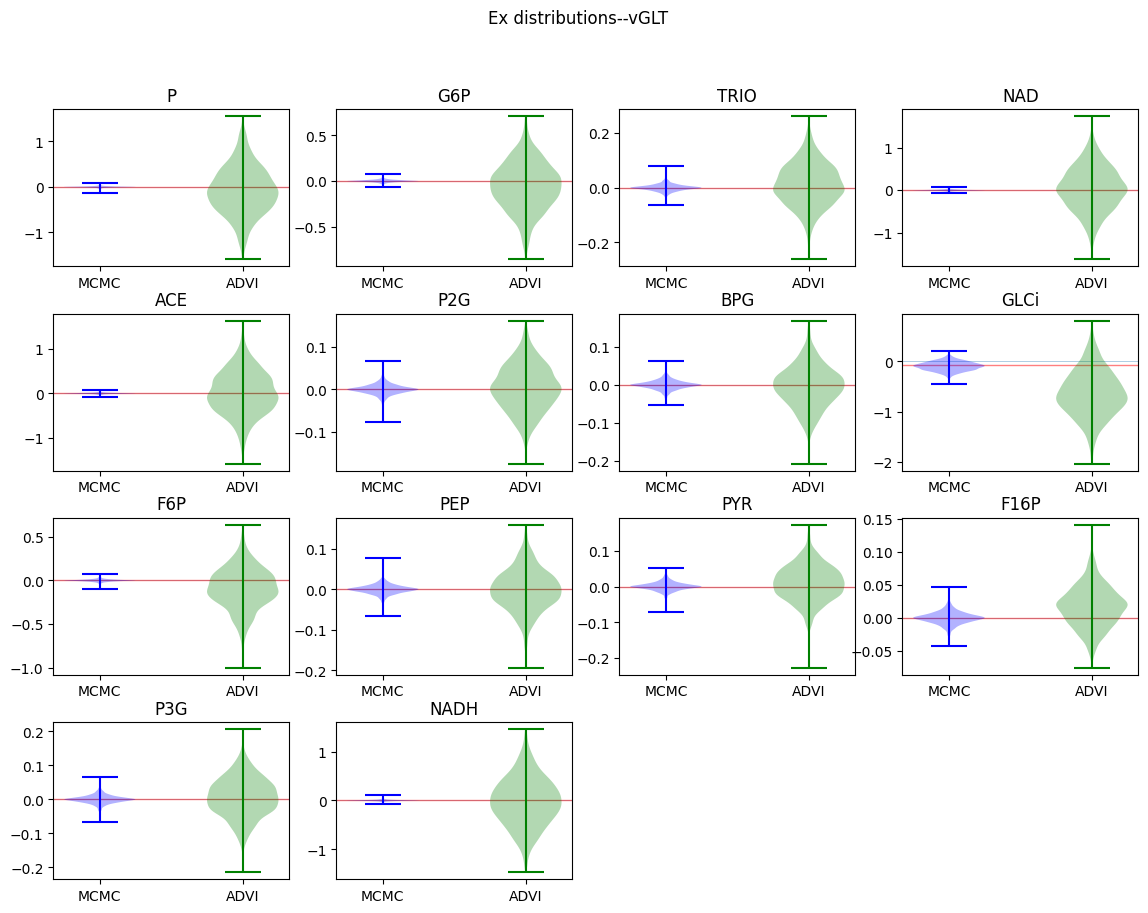

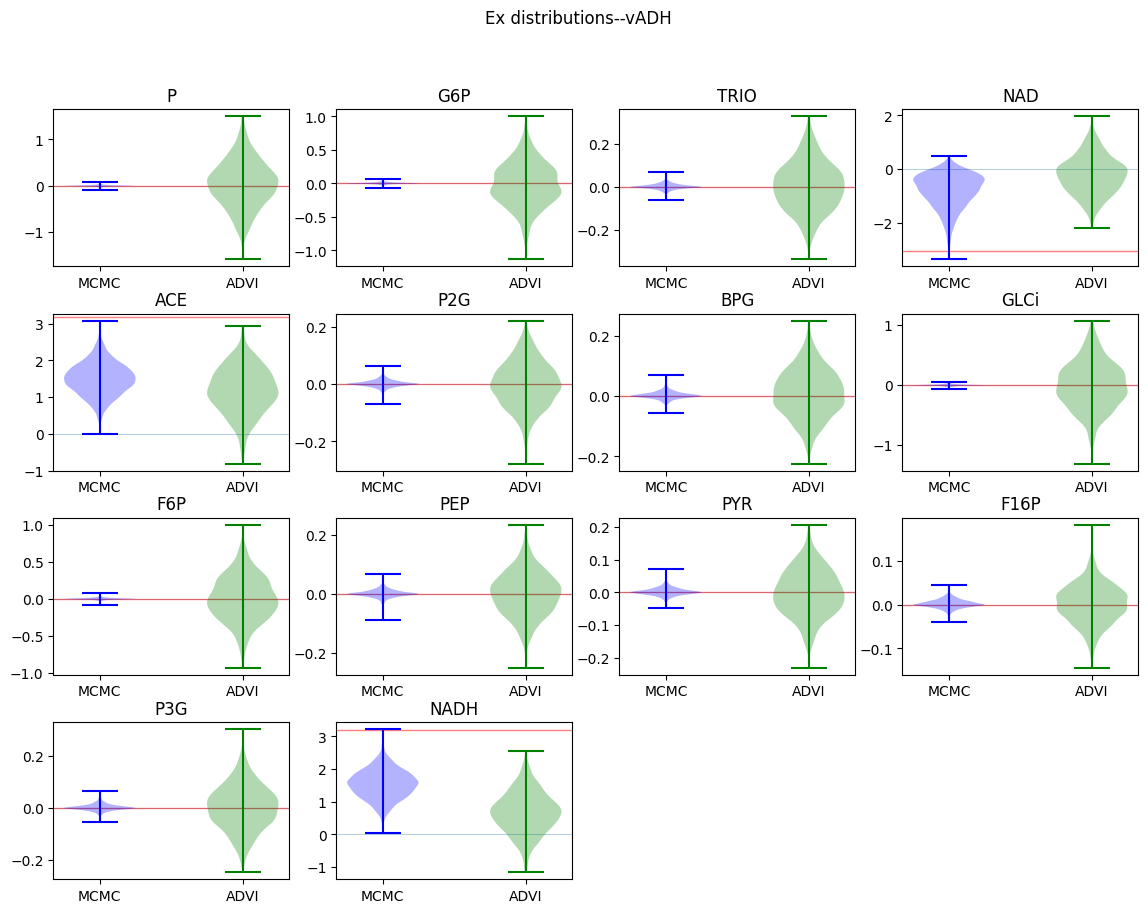

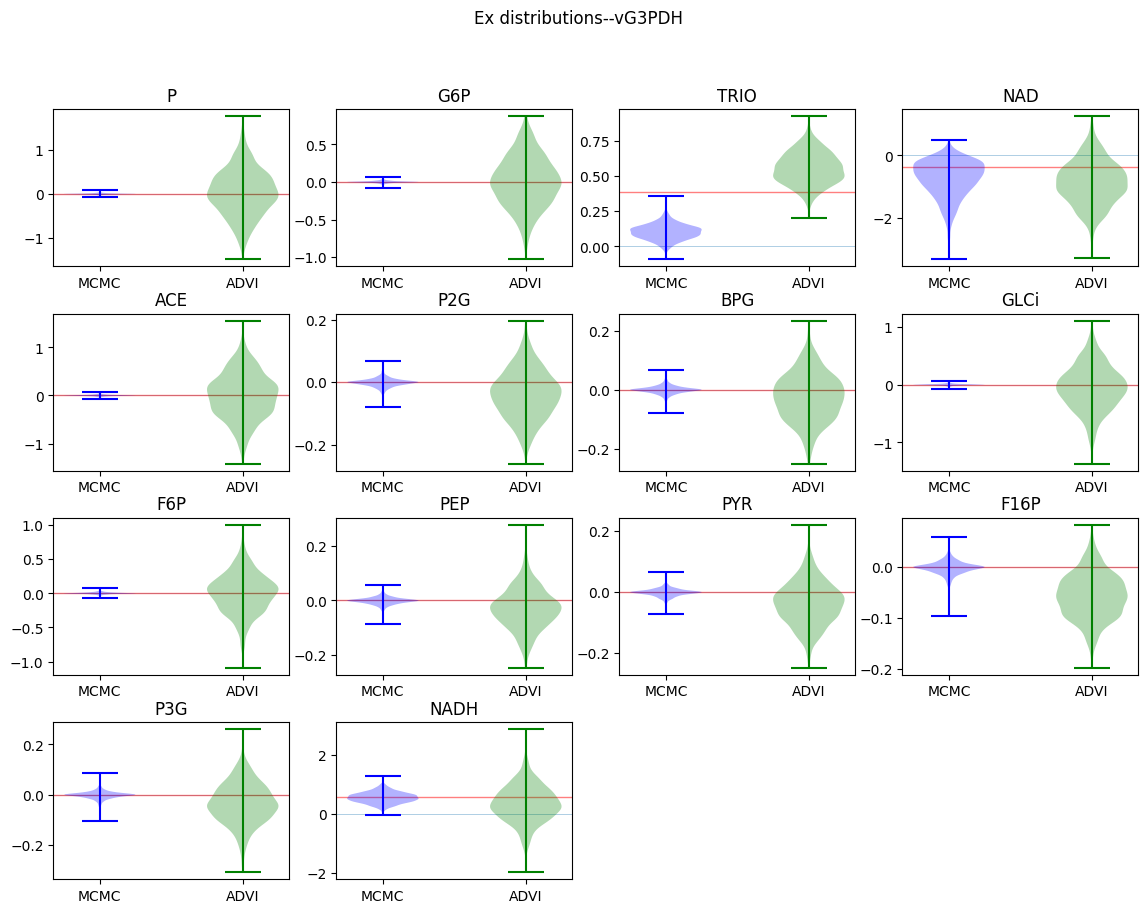

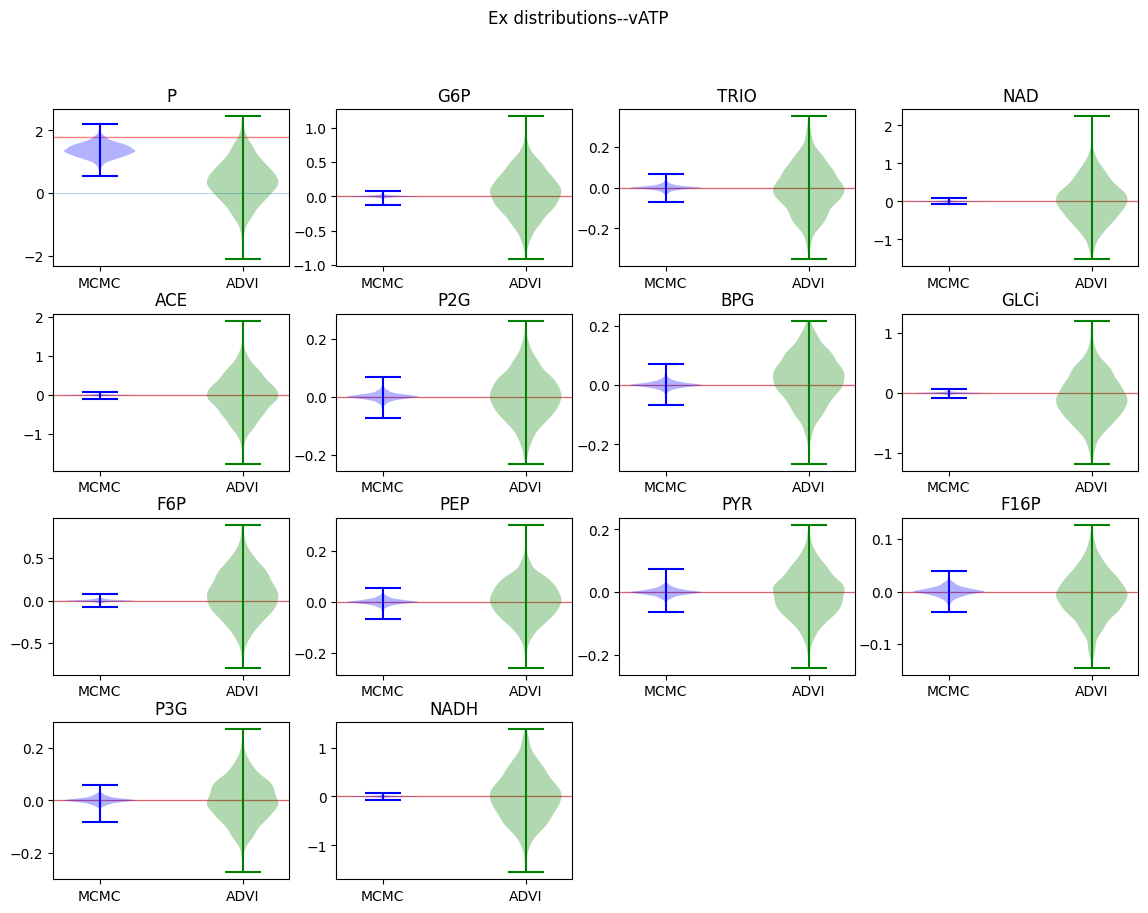

In [33]:
colors = ['blue', 'green', '#fa8602', 'magenta', '#07f53b', '#2312b8']

for i,rxn in enumerate(r.getReactionIds()): #['vADH']
    
    fig, ax = plt.subplots(4,4, figsize = (14,10))
    ii=-1
    
    fig.suptitle(f'Ex distributions--{rxn}\n')
    plt.setp(ax, xticks=range(3), xticklabels=[0,'MCMC', 'ADVI'])
    plt.subplots_adjust(hspace=0.3)
    
    for j,met in enumerate(r.getFloatingSpeciesIds()): # ['TRIO'])
        if j%4==0:
            ii += 1

        met_traces=[]
        for trace in [g.transpose(1, 2, 0), Ex_advi.transpose(1,2,0)]: 
            met_traces.append(trace[i,j,:]) 
            
        met_traces = np.array(met_traces).T

        plots = ax[ii, j%4].violinplot(met_traces)

        # Set the color of the violin patches
        for pc, color in zip(plots['bodies'], colors):
            pc.set_facecolor(color)
        plots['cbars'].set_colors(colors)
        plots['cmaxes'].set_colors(colors)
        plots['cmins'].set_colors(colors)
        
        ax[ii, j%4].axhline(0, linewidth=0.5, zorder=0, alpha=0.5)
        ax[ii, j%4].axhline(r.getScaledElasticityMatrix()[i,j], linewidth=1, zorder=0, alpha=0.5,color='red')
        ax[ii, j%4].set_title(met)
    
    fig.delaxes(ax[3,2]) 
    fig.delaxes(ax[3,3]) 

## Backcalculating to check if there are multiple elasticity solutions

In [143]:
med_Ex = np.median(Ex, axis=0)
med_Ey = np.median(Ey, axis=0)
med_Ex_advi = np.median(Ex_advi, axis=0)
med_Ey_advi = np.median(Ey_advi, axis=0)

In [144]:
BMCA_obj.vn
# d_df is the flux calculated using the Bayesian inference MCMC POSTERIORS for elasticity
MCMC_vn = BMCA_obj.en.values * (np.ones(BMCA_obj.en.T.shape) + med_Ex@(BMCA_obj.xn.T) + med_Ey@(BMCA_obj.yn.T)).T
MCMC_vn_df = pd.DataFrame(MCMC_vn)
MCMC_vn_df.columns = BMCA_obj.vn.columns #r.getReactionIds()
MCMC_vn_df

,v_vGLK,v_vPGI,v_vGLYCO,v_vTreha,v_vPFK,v_vALD,v_vGAPDH,v_vPGK,v_vPGM,v_vENO,v_vPYK,v_vPDC,v_vSUC,v_vGLT,v_vADH,v_vG3PDH,v_vATP
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.057592,1.051475,1.005988,1.006670,1.064569,0.985590,0.978096,1.052865,0.994753,0.990063,1.032810,1.002464,1.024164,1.071192,1.024294,1.002689,1.049679
2,1.019298,1.055523,0.999109,0.997836,1.001111,0.999401,0.999287,1.000844,0.999677,0.999433,1.000620,1.000030,1.000573,1.000912,1.000344,1.000018,1.000882
3,0.999104,0.953794,1.475897,0.983369,0.894271,1.020217,1.045493,0.926708,1.011968,1.027892,0.953003,1.000535,0.961411,0.983494,0.970135,0.997967,0.873227
4,1.000402,0.962010,0.989307,1.483284,0.923402,1.015102,1.031876,0.943435,1.008535,1.019205,0.964019,1.000190,0.972206,0.989182,0.977507,0.998392,0.915869
5,1.013590,1.000627,0.999652,0.998778,1.335285,0.998791,0.998475,1.000685,0.999156,0.998888,1.000455,0.999893,1.000664,1.000728,0.999917,0.999762,1.000442
6,1.002597,0.997992,0.999888,0.999733,0.980472,1.388054,1.000053,1.000122,1.000243,1.000518,1.000449,1.002315,0.999926,1.000178,0.999768,1.000178,1.000081
7,1.009521,1.003292,1.005647,1.005403,0.977265,1.145951,1.224752,1.051802,0.993685,0.985740,1.035137,1.032000,0.910705,1.006698,1.013813,1.022108,1.048449
8,1.000209,1.000224,1.000214,1.000205,0.999266,1.003218,1.018666,1.341062,0.999727,0.999585,1.000798,1.001079,0.997999,1.000223,1.000133,1.000464,1.001138
9,1.000144,1.000411,1.000185,1.000172,0.999417,1.002714,1.015092,1.018243,1.236298,0.999697,1.000735,1.001355,0.998302,1.000189,0.999988,1.000476,1.000887


In [145]:
BMCA_obj.vn
# d_df is the flux calculated using the Bayesian inference ADVI POSTERIORS for elasticity
advi_vn = BMCA_obj.en.values * (np.ones(BMCA_obj.en.T.shape) + med_Ex_advi@(BMCA_obj.xn.T) + med_Ey_advi@(BMCA_obj.yn.T)).T
advi_vn_df = pd.DataFrame(advi_vn)
advi_vn_df.columns = BMCA_obj.vn.columns #r.getReactionIds()
advi_vn_df

,v_vGLK,v_vPGI,v_vGLYCO,v_vTreha,v_vPFK,v_vALD,v_vGAPDH,v_vPGK,v_vPGM,v_vENO,v_vPYK,v_vPDC,v_vSUC,v_vGLT,v_vADH,v_vG3PDH,v_vATP
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.861175,1.041793,0.973395,0.953187,1.029523,1.053704,1.053072,1.016424,1.055115,1.058961,1.023391,1.035392,0.995482,1.457454,1.031615,1.044904,1.110195
2,1.135339,1.168354,0.948164,0.733481,1.003057,0.999188,0.982620,1.001994,0.993792,0.990884,1.000239,1.000877,1.009611,1.021136,1.010023,1.003187,0.984614
3,1.073804,0.938742,1.452564,0.810297,0.859732,1.005470,1.024479,0.933619,0.970672,0.991288,0.940176,1.015814,0.957112,0.939412,0.970783,0.982926,0.899516
4,1.051578,0.952286,0.978144,1.299069,0.900360,1.006216,1.016918,0.951112,0.979153,0.993124,0.953180,1.012042,0.970490,0.963216,0.978756,0.988011,0.930320
5,1.005963,0.967992,0.990029,0.931920,1.329432,0.979290,0.955119,1.009679,0.991839,0.969687,0.998460,0.993851,1.020711,1.050032,1.010663,0.995688,0.963260
6,1.002830,0.992962,0.999094,0.985411,0.980965,1.324516,0.992065,1.002441,1.000771,0.994012,0.996427,1.011149,1.002945,1.006722,1.001648,1.008979,0.993954
7,0.994071,0.995427,1.013072,1.021377,0.988121,1.169084,1.044196,1.058906,1.014027,0.979384,1.019776,1.093276,0.904140,1.038215,0.960715,0.852320,1.022634
8,0.995880,1.000497,1.001809,1.010222,1.001246,1.006007,1.035406,1.396984,0.999610,0.997385,0.998362,1.007653,0.999441,1.001576,0.998049,0.999107,0.997605
9,0.995840,1.001100,1.003028,1.008730,1.000569,1.008373,1.027964,1.004688,1.359538,0.998083,0.995244,1.012246,0.999261,1.000658,0.997972,1.004026,0.998263


Text(0.04, 0.5, 'relative fluxes predicted with Bayesian inference')

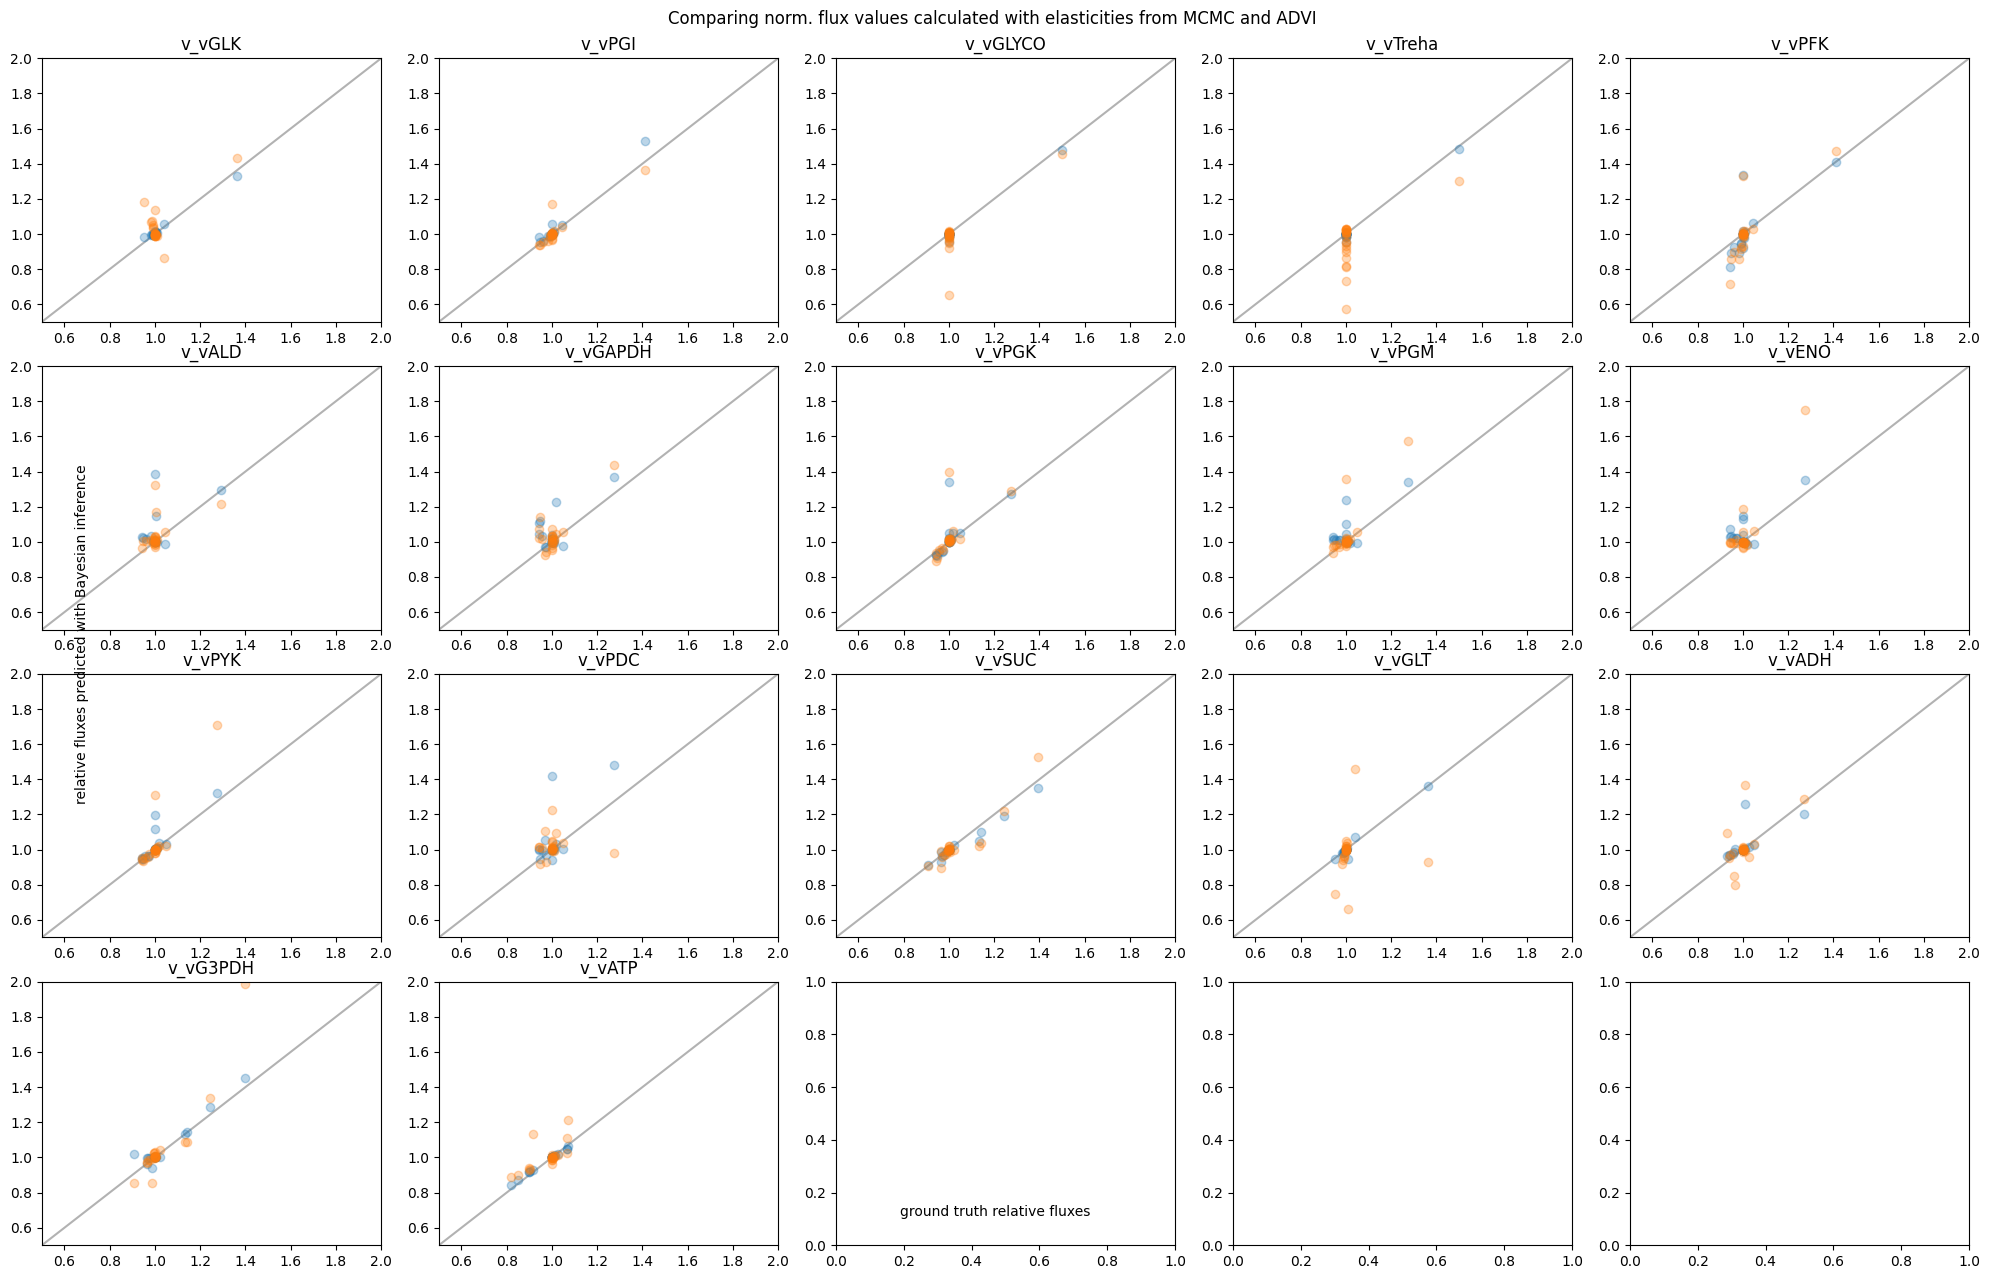

In [151]:
fig, axs = plt.subplots(4,5, figsize=(20, 13)) 
idx_starter = -1

fig.suptitle('Comparing norm. flux values calculated with elasticities from MCMC and ADVI \n')
fig.tight_layout()

lims = [0.5,2]

for i,col in enumerate(MCMC_vn_df.columns): 
    if i%5==0:
      idx_starter += 1
    axs[idx_starter, i%5].plot(lims, lims, 'k-', alpha=0.3, zorder=0)
    axs[idx_starter, i%5].scatter(BMCA_obj.vn[col], MCMC_vn_df[col], alpha=0.3)
    axs[idx_starter, i%5].scatter(BMCA_obj.vn[col], advi_vn_df[col], alpha=0.3)
    axs[idx_starter, i%5].set_xlim(lims)
    axs[idx_starter, i%5].set_ylim(lims)
    #axs[idx_starter, i%5].set_xlabel('ground truth relative fluxes\n\n')
    #axs[idx_starter, i%5].set_ylabel('relative fluxes predicted with Bayesian inference')
    axs[idx_starter, i%5].set_title(col)

fig.text(0.5, 0.04, 'ground truth relative fluxes\n', ha='center')
fig.text(0.04, 0.5, 'relative fluxes predicted with Bayesian inference', va='center', rotation='vertical')


#plt.legend(["fully parameterized", "Visser priors", "real values"])
#plt.show()

### Subtracting the vn values from fluxes calculated using elasticity posteriors

In [155]:
mcmc_dif = MCMC_vn_df-BMCA_obj.vn
mcmc_dif[mcmc_dif < 1E-1] = 0 
mcmc_dif

,v_vGLK,v_vPGI,v_vGLYCO,v_vTreha,v_vPFK,v_vALD,v_vGAPDH,v_vPGK,v_vPGM,v_vENO,v_vPYK,v_vPDC,v_vSUC,v_vGLT,v_vADH,v_vG3PDH,v_vATP
0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
1,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
2,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
3,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.102698,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
4,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
5,0.0,0.000000,0.0,0.0,0.33472,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
6,0.0,0.000000,0.0,0.0,0.00000,0.387930,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
7,0.0,0.000000,0.0,0.0,0.00000,0.140395,0.206104,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.114736,0.0
8,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.340608,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
9,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.235932,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0


In [156]:
advi_dif = advi_vn_df-BMCA_obj.vn
advi_dif[advi_dif < 1E-1] = 0 
advi_dif

,v_vGLK,v_vPGI,v_vGLYCO,v_vTreha,v_vPFK,v_vALD,v_vGAPDH,v_vPGK,v_vPGM,v_vENO,v_vPYK,v_vPDC,v_vSUC,v_vGLT,v_vADH,v_vG3PDH,v_vATP
0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.418653,0.000000,0.000000,0.000000
2,0.134675,0.167597,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.0,0.0,0.328867,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.0,0.0,0.000000,0.324393,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.0,0.0,0.000000,0.163529,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.39653,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.359172,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Will the fitting be better if perturbations are smaller?

In [157]:
BIOMD64_09 = BMCA.BMCA(Teusink_ant, '../../data/interim/generated_data/ogTeusink/BIOMD0000000064_e_extANDenzyme0.9perts.csv')

Model does not contain SBML fbc package information.
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPGI>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPGI>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLYCO>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLYCO>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vTreha>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vTreha>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPFK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPFK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vALD>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vALD>'
Missing lower flux bound set to '-1000.0' for reaction: '

../../data/interim/Antimony/BIOMD0000000064_e_cobra.ant


In [158]:
with pm.Model() as pymc_model:
    
    # Initialize elasticities
    Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BIOMD64_09.Ex.to_numpy(), name='Ex'))
    Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BIOMD64_09.Ey.to_numpy(), name='Ey'))
    e_obs = pm.Normal('e_obs', mu=1, sigma=1, observed=BIOMD64_09.en.T)
    pm.Deterministic('en', e_obs)
    chi_obs = pm.Normal('chi_obs', mu=0, sigma=10, observed=BIOMD64_09.xn.T)
    pm.Deterministic('chin', chi_obs)
    y_obs = pm.Normal('y_obs', mu=0, sigma=10, observed=BIOMD64_09.yn.T)
    pm.Deterministic('yn', y_obs)
    likelihood = pm.Deterministic('vn', e_obs * (np.ones(BIOMD64_09.en.T.shape) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))
    v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BIOMD64_09.vn.squeeze().T)
    pm.Deterministic('v_hat', v_hat_obs)

    trace_09 = pm.sample(1000, random_seed=1, cores=4)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Ex_kinetic_entries, Ex_capacity_entries, Ey_kinetic_entries, Ey_capacity_entries]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5765 seconds.


Finished [100%]: Average Loss = 1,789.5


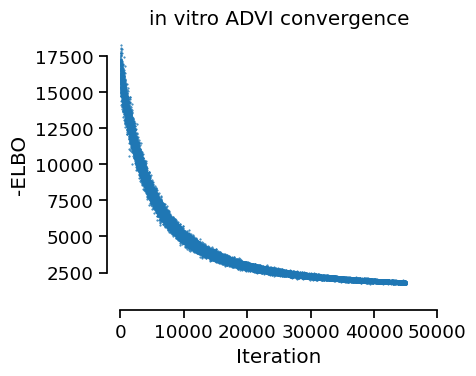

In [159]:
trace_ADVI_09 = run_ADVI(BIOMD64_09)

In [160]:
Ex_09 = (trace_09['posterior']['Ex']).to_numpy()
Ey_09 = (trace_09['posterior']['Ey']).to_numpy()

Ex_09 = reshape_elasticity(Ex_09)
Ey_09 = reshape_elasticity(Ey_09)

Ex_advi_09 = (trace_ADVI_09['posterior']['Ex']).to_numpy().squeeze()
Ey_advi_09 = (trace_ADVI_09['posterior']['Ey']).to_numpy().squeeze()

In [161]:
med_Ex_09 = np.median(Ex_09, axis=0)
med_Ey_09 = np.median(Ey_09, axis=0)
med_Ex_advi_09 = np.median(Ex_advi_09, axis=0)
med_Ey_advi_09 = np.median(Ey_advi_09, axis=0)

In [162]:
BIOMD64_09.vn
# flux calculated using the Bayesian inference MCMC POSTERIORS for elasticity
MCMC_vn_09 = BIOMD64_09.en.values * (np.ones(BIOMD64_09.en.T.shape) + med_Ex@(BIOMD64_09.xn.T) + med_Ey@(BIOMD64_09.yn.T)).T
MCMC_vn_df_09 = pd.DataFrame(MCMC_vn_09)
MCMC_vn_df_09.columns = BIOMD64_09.vn.columns #r.getReactionIds()
MCMC_vn_df_09

,v_vGLK,v_vPGI,v_vGLYCO,v_vTreha,v_vPFK,v_vALD,v_vGAPDH,v_vPGK,v_vPGM,v_vENO,v_vPYK,v_vPDC,v_vSUC,v_vGLT,v_vADH,v_vG3PDH,v_vATP
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.983472,0.977888,0.996740,0.996457,0.968836,1.007046,1.010069,0.978307,1.002244,1.004354,0.986221,0.999282,0.987676,0.976295,0.987784,0.998798,0.973603
2,0.994185,0.983382,1.000272,1.000669,0.999584,1.000203,1.000246,0.999684,1.000106,1.000187,0.999775,0.999989,0.999794,0.999659,0.999866,0.999992,0.999667
3,0.999621,1.012462,0.902512,1.002938,1.022276,0.995710,0.990044,1.021214,0.996969,0.993435,1.013543,0.999866,1.007301,1.002747,1.005565,1.000362,1.021896
4,0.999650,1.009268,1.001946,0.901848,1.015883,0.996848,0.993174,1.014456,0.997978,0.995678,1.009184,0.999968,1.005373,1.001909,1.004312,1.000306,1.015250
5,0.995487,1.006879,1.000124,1.000423,0.930358,1.000396,1.000500,0.999737,1.000270,1.000362,0.999826,1.000031,0.999766,0.999721,1.000001,1.000071,0.999809
6,0.999070,1.001009,1.000040,1.000096,1.006893,0.922879,0.999987,0.999954,0.999920,0.999827,0.999845,0.999212,1.000022,0.999935,1.000078,0.999940,0.999969
7,0.996693,1.000217,0.998466,0.998577,1.011455,0.965082,0.944581,0.988505,1.001397,1.003326,0.992222,0.991588,1.021600,0.998103,0.996636,0.996064,0.986641
8,0.999928,0.999931,0.999931,0.999934,1.000252,0.998934,0.994288,0.929645,1.000087,1.000135,0.999738,0.999648,1.000663,0.999927,0.999952,0.999849,0.999621
9,0.999950,0.999870,0.999939,0.999943,1.000202,0.999088,0.995228,0.994658,0.949898,1.000101,0.999756,0.999558,1.000570,0.999937,0.999999,0.999844,0.999699


In [163]:
# flux calculated using the Bayesian inference ADVI POSTERIORS for elasticity
advi_vn_09 = BMCA_obj.en.values * (np.ones(BIOMD64_09.en.T.shape) + med_Ex_advi@(BIOMD64_09.xn.T) + med_Ey_advi@(BIOMD64_09.yn.T)).T
advi_vn_df_09 = pd.DataFrame(advi_vn_09)
advi_vn_df_09.columns = BIOMD64_09.vn.columns #r.getReactionIds()
advi_vn_df_09

,v_vGLK,v_vPGI,v_vGLYCO,v_vTreha,v_vPFK,v_vALD,v_vGAPDH,v_vPGK,v_vPGM,v_vENO,v_vPYK,v_vPDC,v_vSUC,v_vGLT,v_vADH,v_vG3PDH,v_vATP
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.711174,0.979687,1.005446,0.996044,0.976773,0.984635,0.983614,0.990064,0.979476,0.978532,0.988010,0.990714,0.996514,0.852186,0.985997,0.983493,0.956113
2,0.957995,1.603680,1.016230,1.083375,0.998996,1.000217,1.005399,0.999354,1.001895,1.002802,0.999899,0.999703,0.996988,0.993038,0.996833,0.998965,1.004713
3,0.985929,1.014934,1.509080,1.037616,1.028237,0.997716,0.993531,1.016879,1.005560,1.000296,1.018135,0.995710,1.007207,1.008068,1.005207,1.002733,1.019327
4,0.989925,1.010924,1.004269,1.540205,1.020058,0.998162,0.995815,1.011523,1.004047,1.000694,1.012311,0.997089,1.005269,1.005476,1.003953,1.002065,1.013622
5,0.995120,1.015125,1.004320,1.027344,1.552347,1.006372,1.014208,0.996959,1.002632,1.009519,1.000452,1.001858,0.993391,0.983884,0.996459,1.001228,1.011618
6,0.998883,1.002712,1.000389,1.005416,1.006732,1.559834,1.002821,0.999144,0.999761,1.002116,1.001219,0.996215,0.998940,0.997565,0.999403,0.996947,1.002155
7,1.001010,1.003601,0.996831,0.997815,1.008416,0.962571,1.626045,0.985323,0.996164,1.006518,0.997874,0.973829,1.022024,0.987212,1.008927,1.042095,0.995630
8,1.001283,0.999853,0.999431,0.996817,0.999630,0.998063,0.989146,1.532003,1.000114,1.000826,1.000507,0.997570,1.000214,0.999485,1.000623,1.000358,1.000737
9,1.001330,0.999656,0.999034,0.997204,0.999827,0.997290,0.991146,0.998779,1.544290,1.000623,1.001505,0.996074,1.000262,0.999770,1.000658,0.998788,1.000552


Text(0.04, 0.5, 'relative fluxes predicted with Bayesian inference')

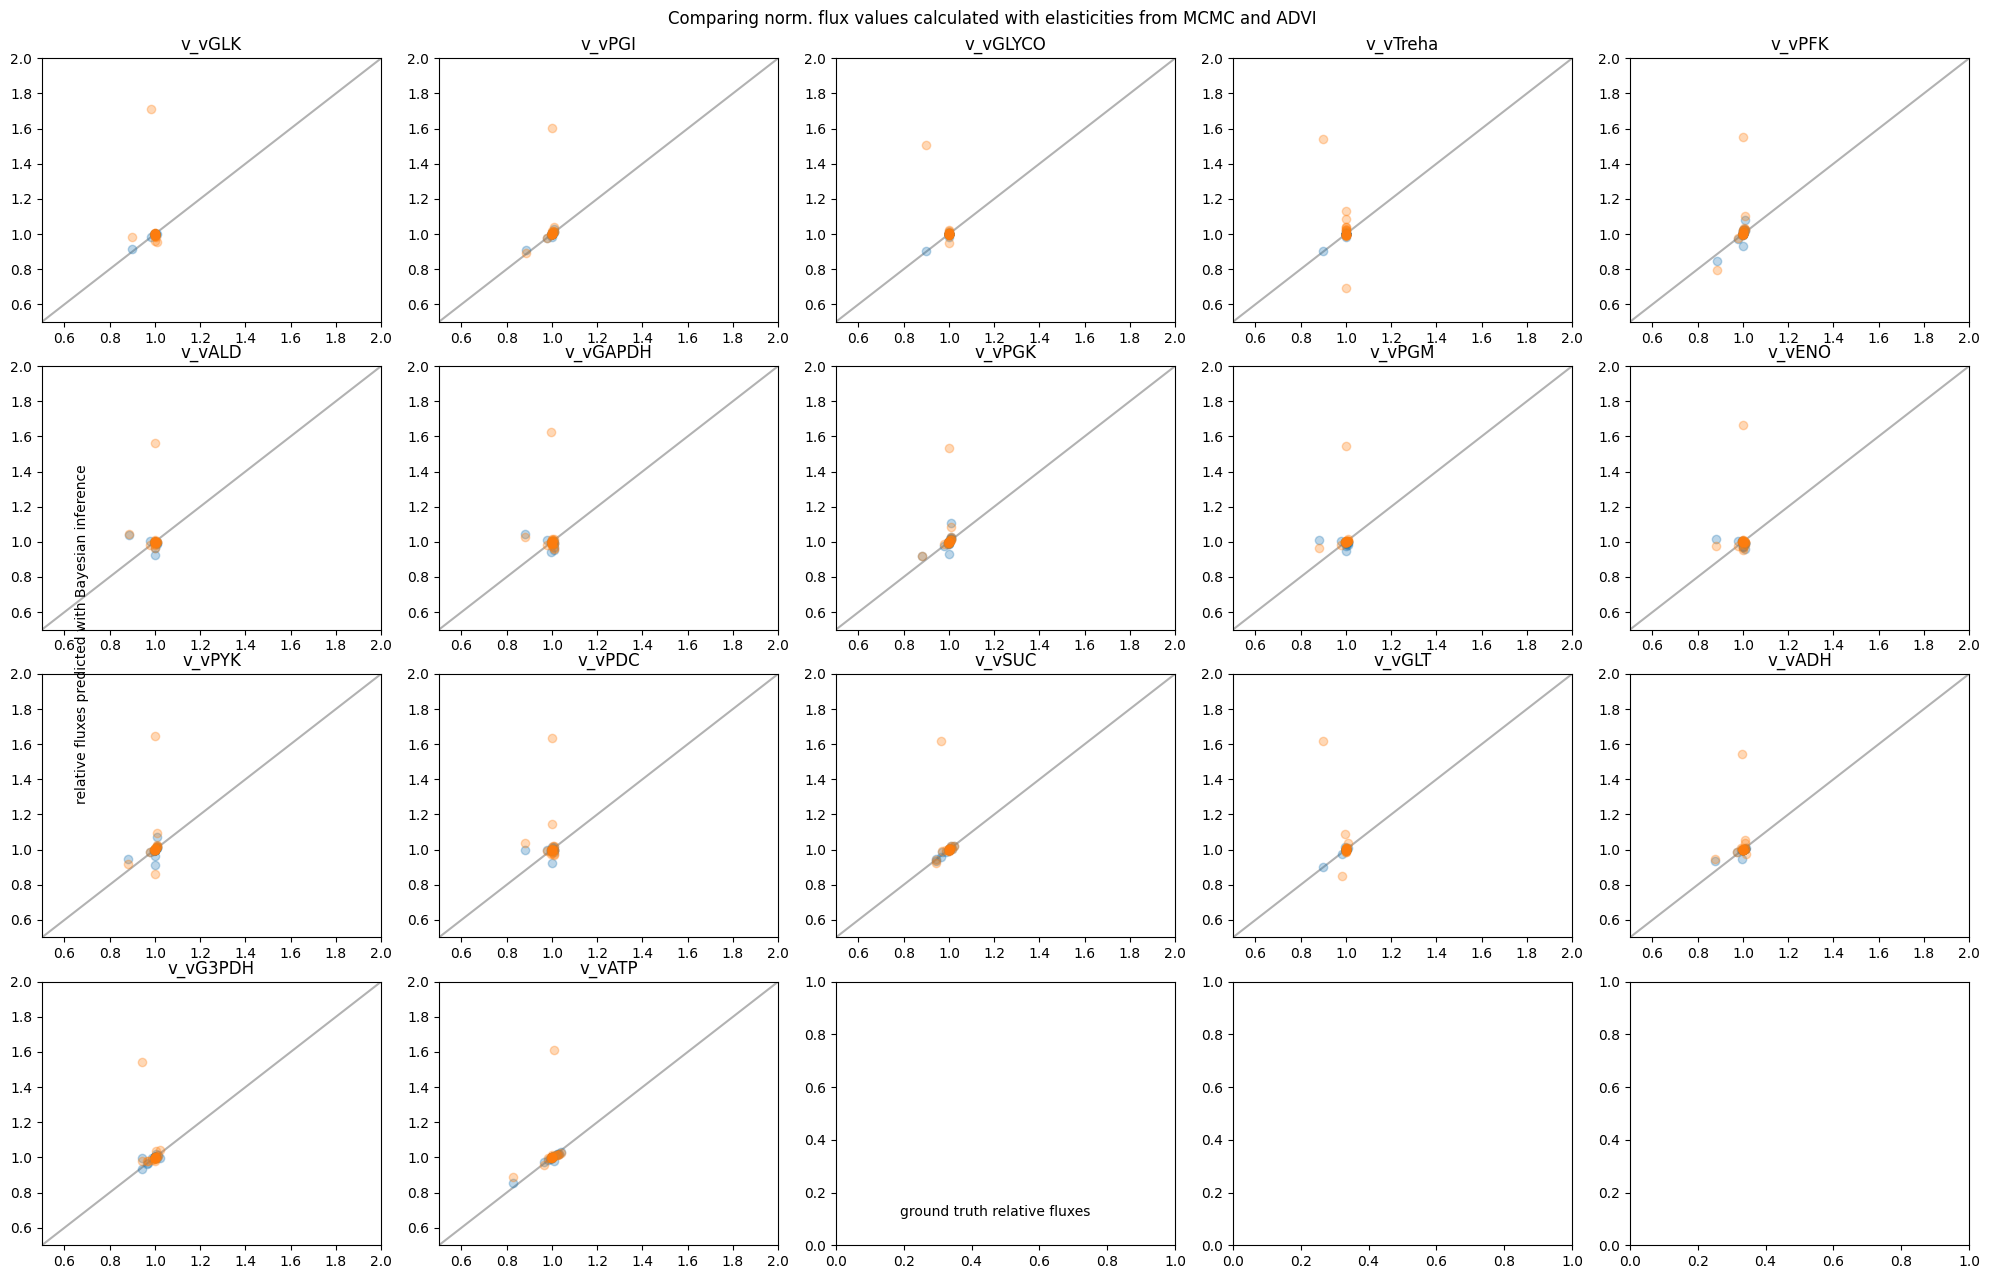

In [164]:
fig, axs = plt.subplots(4,5, figsize=(20, 13)) 
idx_starter = -1

fig.suptitle('Comparing norm. flux values calculated with elasticities from MCMC and ADVI \n')
fig.tight_layout()

lims = [0.5,2]

for i,col in enumerate(MCMC_vn_df.columns): 
    if i%5==0:
      idx_starter += 1
    axs[idx_starter, i%5].plot(lims, lims, 'k-', alpha=0.3, zorder=0)
    axs[idx_starter, i%5].scatter(BIOMD64_09.vn[col], MCMC_vn_df_09[col], alpha=0.3)
    axs[idx_starter, i%5].scatter(BIOMD64_09.vn[col], advi_vn_df_09[col], alpha=0.3)
    axs[idx_starter, i%5].set_xlim(lims)
    axs[idx_starter, i%5].set_ylim(lims)
    #axs[idx_starter, i%5].set_xlabel('ground truth relative fluxes\n\n')
    #axs[idx_starter, i%5].set_ylabel('relative fluxes predicted with Bayesian inference')
    axs[idx_starter, i%5].set_title(col)

fig.text(0.5, 0.04, 'ground truth relative fluxes\n', ha='center')
fig.text(0.04, 0.5, 'relative fluxes predicted with Bayesian inference', va='center', rotation='vertical')


#plt.legend(["fully parameterized", "Visser priors", "real values"])
#plt.show()

In [165]:
mcmc_dif_09 = MCMC_vn_df_09-BIOMD64_09.vn
mcmc_dif_09[mcmc_dif_09 < 1E-1] = 0 
mcmc_dif_09

,v_vGLK,v_vPGI,v_vGLYCO,v_vTreha,v_vPFK,v_vALD,v_vGAPDH,v_vPGK,v_vPGM,v_vENO,v_vPYK,v_vPDC,v_vSUC,v_vGLT,v_vADH,v_vG3PDH,v_vATP
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [166]:
advi_dif_09 = advi_vn_df_09-BIOMD64_09.vn
advi_dif_09[advi_dif_09 < 1E-1] = 0 
advi_dif_09

,v_vGLK,v_vPGI,v_vGLYCO,v_vTreha,v_vPFK,v_vALD,v_vGAPDH,v_vPGK,v_vPGM,v_vENO,v_vPYK,v_vPDC,v_vSUC,v_vGLT,v_vADH,v_vG3PDH,v_vATP
0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
1,0.730668,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
2,0.000000,0.603966,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.60908,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.00000,0.640205,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.00000,0.000000,0.552569,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.00000,0.000000,0.000000,0.559880,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.631083,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.532154,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.544414,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
